In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
cd ../src

/home/theo/kaggle/birds/src


In [182]:
import re
import gc
import os
import time
import random
import operator
import datetime
import soundfile
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.io.wavfile import write
from audiomentations import Resample
from sklearn.model_selection import *

In [183]:
from params import *

## Np check

In [184]:
import numpy as np

n = 100

a = np.random.rand(128, n)
b = np.random.rand(n, 1594)

%time c = np.dot(a, b)

CPU times: user 2.83 ms, sys: 1.9 ms, total: 4.73 ms
Wall time: 2.98 ms


## norm

In [213]:
def resize_and_transpose(image, size):
    if size is not None:
        h, w, _ = image.shape
        new_w, new_h = int(w * size / h), size
        image = cv2.resize(image, (new_w, new_h))
        
    image = np.moveaxis(image, 2, 0)
    
    return (image / 255.0).astype(np.float32)


def mono_to_color(X: np.ndarray, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    
    if (_max - _min) > eps:
        V = np.clip(X, norm_min, norm_max)
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(X, dtype=np.uint8)
    return V



In [207]:
def mono_to_color2(X, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def resize(image, size=None):
    if size is not None:
        h, w, _ = image.shape
        new_w, new_h = int(w * size / h), size
        # image = cv2.resize(image, (new_w, new_h))

    return image


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return np.moveaxis(image, 2, 0).astype(np.float32)

In [220]:
melspec = np.random.random((100, 100)) * 100
melspec = np.zeros((100, 100)) * 100


image = mono_to_color2(melspec)
image = resize(image, None)
image = normalize(image, mean=None, std=None)

image_ = mono_to_color(melspec)
image_ = resize(image_, None)
image_ = normalize(image_, mean=None, std=None)

In [221]:
image.shape

(3, 100, 100)

In [222]:
(image == image_).all()

True

In [206]:
for i in range(1):
    X = np.zeros((1, 100, 100))
#     X = np.random.random((1, 100, 100))
    y2 = mono_to_color2(X)
    y = mono_to_color(X)
    
    print((y == y2).all())
#     if not (y == y2).all():
#         print(X)
        
    break

True


True

### effnet

In [185]:
from efficientnet_pytorch import EfficientNet

In [179]:
model = EfficientNet.from_pretrained("efficientnet-b0", {"image_size": 256, "include_top": False})

Loaded pretrained weights for efficientnet-b0


In [173]:
x = torch.randn(1, 3, 128, 128)

In [176]:
y = model(x)

In [178]:
y.size()

torch.Size([1, 1000])

In [160]:
# model._global_params.include_top = False

AttributeError: can't set attribute

## Normalize

In [130]:
from data.transforms import *

In [131]:
X = (np.random.random((100, 100)) * 2 - 1) * 10

In [132]:
X.shape

(100, 100)

In [133]:
X.min()

-9.990616298773634

In [134]:
X = mono_to_color(X)

In [135]:
X.shape

(100, 100, 3)

In [136]:
X = resize(X)

In [137]:
X.shape

(100, 100, 3)

In [138]:
X.mean(0).mean(0) / 255

array([0.49755137, 0.49755137, 0.49755137])

In [139]:
X = normalize(X, MEAN, STD)

In [143]:
X.mean(-1).mean(-1) * STD + MEAN

array([0.49755138, 0.49755138, 0.49755138])

## Mixup distribution

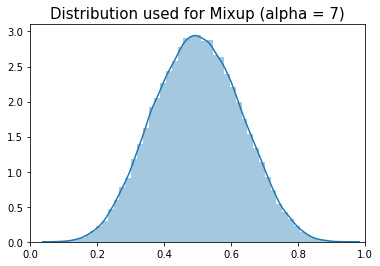

In [329]:
alpha_ = 7
sns.distplot(np.random.beta(alpha_, alpha_, 100000))
plt.xlim(0, 1)
plt.title(f'Distribution used for Mixup (alpha = {alpha_})', size=15)
plt.show()

## Background data

In [330]:
background_data = pd.read_csv(DATA_PATH + "ff1010bird_metadata_2018.csv")
background_data = background_data[background_data['hasbird'] == 0]

In [331]:
idx = np.random.choice(background_data['itemid'])
y, sr = soundfile.read("../../../data/wav/" + str(idx) + ".wav")

print(idx)
ipd.Audio(y, rate=sr)

139095


In [290]:
resample = Resample(min_sample_rate=32000, max_sample_rate=32000, p=1)

for path in os.listdir(BACKGROUND_PATH):
    y, sr = soundfile.read(BACKGROUND_PATH + path)

    if sr != 32000:
        y_r = resample(samples=y, sample_rate=sr)
        write(BACKGROUND_PATH + path, 32000, y_r)
        
        print(f'Resampled {path}')

NameError: name 'Resample' is not defined

In [341]:
p = np.random.choice(os.listdir(BACKGROUND_PATH))
y, sr = soundfile.read(BACKGROUND_PATH + p)
print(p)
ipd.Audio(y, rate=sr)

ORANGE_301.0_304.8.wav


## Test examples

In [312]:
ex1_path = DATA_PATH + "example_test_audio/ORANGE-7-CAP_20190606_093000.pt623.wav"
ex2_path = DATA_PATH + "example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.wav"

In [313]:
check_path = "../output/ORANGE_184.8_189.6.wav"

In [320]:
y, sr = soundfile.read(check_path)

In [322]:
sr

32000

In [323]:
ipd.Audio(y, rate=sr)

In [302]:
lapse = 0 + np.array([0, 20])
lapse

array([ 0, 20])

In [303]:
ipd.Audio(y[int(lapse[0] * sr) : int(lapse[1] * sr), 0], rate=sr)

In [315]:
# ORANGE-7-CAP_20190606_093000.pt623.wav
lapses = [
    [10.1, 13.5],
    [27, 31],
    [47, 50.5],
    [52, 55],
    [58, 61],
    [120.5, 124. ],
    [160.5, 167. ],
    [184.8, 189.6],
    [196.5, 199.5],
    [204.2, 209.2],
    [236.2, 240.7],
    [243.2, 247.2], 
    [263.2, 267. ],
    [301. , 304.8],
]

In [318]:
# BLKFR-10-CPL_20190611_093000.pt540.wav
lapses = [
    [88.7, 93.2],
    [122, 128],
    [149, 157],
    [156, 163],
    [162, 168],
    [183.2, 188.2],
    [189.5, 193.5],
    [197, 203]
]

### Saving

In [319]:
resample = Resample(min_sample_rate=32000, max_sample_rate=32000, p=1)

for lapse in lapses:
    sample = y[int(lapse[0] * sr) : int(lapse[1] * sr), 0]
    if lapse[1] - lapse[0] < 5:
        sample = np.concatenate((sample, sample[::-1]))
        
    if sr != 32000:
        sample = resample(samples=sample, sample_rate=sr)

    write(f"../output/BLKFR_{lapse[0]}_{lapse[1]}.wav", 32000, sample)

In [332]:
os.listdir(BACKGROUND_PATH)

['ORANGE_204.2_209.2.wav',
 'ORANGE_236.2_240.7.wav',
 '189862.wav',
 'ORANGE_120.5_124.0.wav',
 'BLKFR_189.5_193.5.wav',
 'BLKFR_122_128.wav',
 'BLKFR_162_168.wav',
 'ORANGE_27_31.wav',
 'ORANGE_243.2_247.2.wav',
 'ORANGE_52_55.wav',
 'ORANGE_184.8_189.6.wav',
 'ORANGE_58_61.wav',
 '73254.wav',
 'ORANGE_301.0_304.8.wav',
 'BLKFR_183.2_188.2.wav',
 'BLKFR_156_163.wav',
 'ORANGE_160.5_167.0.wav',
 'BLKFR_149_157.wav',
 '54539.wav',
 '141977.wav',
 'ORANGE_196.5_199.5.wav',
 '65252.wav',
 '52114.wav',
 'ORANGE_10.1_13.5.wav',
 'ORANGE_47_50.5.wav',
 '90345.wav',
 '102090.wav',
 '187090.wav',
 'BLKFR_197_203.wav',
 'ORANGE_263.2_267.0.wav',
 '72222.wav',
 'BLKFR_88.7_93.2.wav']

## loading times

In [342]:
df_train = pd.read_csv(DATA_PATH + 'train.csv')

In [346]:
df_train[df_train['duration'] > 500]

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
824,2.5,no,amewoo,1 (mono),2011-05-25,Not specified,554,XC305896.mp3,Not specified,American Woodcock,...,305896,https://www.xeno-canto.org/305896,United States,Paul Marvin,Scolopax minor_American Woodcock,-88.9155,Not specified,21:03,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...
825,3.5,no,amewoo,1 (mono),2011-05-28,Not specified,592,XC306348.mp3,Not specified,American Woodcock,...,306348,https://www.xeno-canto.org/306348,United States,Paul Marvin,Scolopax minor_American Woodcock,-95.4604,Not specified,21:05,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...
839,3.5,no,amewoo,2 (stereo),2016-05-14,level,547,XC325435.mp3,level,American Woodcock,...,325435,https://www.xeno-canto.org/325435,United States,Daniel Parker,Scolopax minor_American Woodcock,Not specified,0-3(s),4:30,Daniel Parker,Creative Commons Attribution-NonCommercial-Sha...
877,3.5,no,amtspa,1 (mono),2013-03-31,Not specified,604,XC127999.mp3,Not specified,American Tree Sparrow,...,127999,https://www.xeno-canto.org/127999,United States,Jonathon Jongsma,Spizelloides arborea_American Tree Sparrow,-93.3698,Not specified,07:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1340,5.0,NaN,banswa,2 (stereo),2013-06-24,Not specified,600,XC140280.mp3,Not specified,Sand Martin,...,140280,https://www.xeno-canto.org/140280,Canada,Patrick Turgeon,Riparia riparia_Bank Swallow,-103.5795,Not specified,14:44,Patrick Turgeon,Creative Commons Attribution-NonCommercial-Sha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18976,5.0,no,veery,1 (mono),2019-05-25,Not specified,511,XC477175.mp3,Not specified,Veery,...,477175,https://www.xeno-canto.org/477175,United States,Matt Wistrand,Catharus fuscescens_Veery,-88.1756,Not specified,06:03,Matt Wistrand,Creative Commons Attribution-NonCommercial-Sha...
19081,5.0,no,vesspa,1 (mono),2019-06-11,Not specified,740,XC482286.mp3,Not specified,Vesper Sparrow,...,482286,https://www.xeno-canto.org/482286,United States,Ed Pandolfino,Pooecetes gramineus_Vesper Sparrow,-115.1471,Not specified,05:55,Ed Pandolfino,Creative Commons Attribution-NonCommercial-Sha...
19082,5.0,no,vesspa,1 (mono),2019-06-11,Not specified,620,XC482287.mp3,Not specified,Vesper Sparrow,...,482287,https://www.xeno-canto.org/482287,United States,Ed Pandolfino,Pooecetes gramineus_Vesper Sparrow,-115.1474,Not specified,06:43,Ed Pandolfino,Creative Commons Attribution-NonCommercial-Sha...
20382,3.5,no,winwre3,1 (mono),2014-11-10,Not specified,503,XC211193.mp3,Not specified,Winter Wren,...,211193,https://www.xeno-canto.org/211193,United States,Paul Marvin,Troglodytes hiemalis_Winter Wren,-80.7749,Not specified,07:17,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...


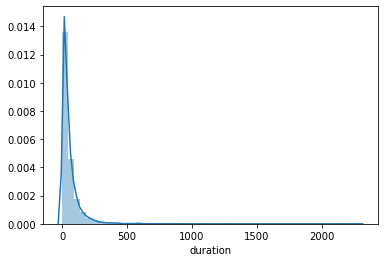

In [345]:
sns.distplot(df_train['duration'])